# **Modelado para Series de Tiempo**

In [79]:
import pandas as pd

In [151]:
ipc = pd.read_csv('ipc.csv')

<Axes: >

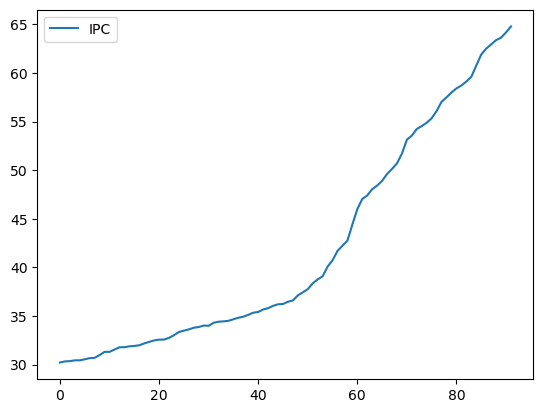

In [81]:
ipc.plot()

Se ve que no es estacionaria

## **Transformación de Box-Cox**

##### **Explicacion**

La transformación de Box-Cox es una familia de transformaciones de potencia que busca estabilizar la varianza y hacer que los datos sigan una distribución más normal. Se define matemáticamente como:  

$$
y^{*} =
\begin{cases} 
\frac{y^{\lambda} - 1}{\lambda}, & \lambda \neq 0 \\
\ln(y), & \lambda = 0
\end{cases}
$$

Se Usa en Series de Tiempo porque 
1. Estabiliza la varianza en datos con heterocedasticidad.  
2. Mejora la normalidad, lo que facilita el modelado con ARIMA o regresión. 

Cuando decimos que los datos "siguen una distribución más normal" después de aplicar la transformación de Box-Cox, nos referimos a que la forma de la distribución de los datos se acerca más a una distribución normal $N(\mu, \sigma^2)$.

Cuando aplicamos la transformación de Box-Cox a una serie de tiempo, buscamos que los datos transformados tengan una distribución más cercana a la normal en el sentido de que:  

1. Los residuos del modelo sean normales.  
2. Se reduzca la asimetría y se estabilice la varianza.
3.  Mejora la aplicabilidad de métodos estadísticos. Pruebas como Dickey-Fuller para estacionariedad funcionan mejor con datos más simétricos.

**Problema Común:**  
Supongamos que tienes una serie de tiempo como el IPC que crece con el tiempo y tiene alta varianza en valores recientes. Esto significa que:  
- La serie no es estacionaria.  
- Los residuos de un modelo pueden ser sesgados y no normales.  

**Solución con Box-Cox:**  
- Box-Cox ajusta la escala de los datos.  
- Reduce el efecto de valores extremos.  
- Hace que la serie sea más "normal" para mejorar los modelos. 

**Interpretación del Parámetro $\lambda$**
El parámetro $\lambda$ controla la forma de la transformación:  

$\lambda = 1$: No hay cambio ($y^* = y$)  
$\lambda = 0$: Se usa el logaritmo natural ($y^* = \ln(y)$)  
$\lambda > 1$: Expande los valores grandes (convexa)  
$0 < \lambda < 1$: Suaviza la varianza  
$\lambda < 0$: Invierte el orden y reduce la dispersión


**¿Cómo se Estima $\lambda$?**

El valor óptimo de $\lambda$ se elige maximizando la verosimilitud. Específicamente, se encuentra el $\lambda$ que maximiza la log-verosimilitud bajo la suposición de normalidad de los datos transformados:

$$
\log L(\lambda) = -\frac{n}{2} \log \left( \frac{1}{n} \sum (y^* - \bar{y^*})^2 \right) + (\lambda - 1) \sum \ln(y)
$$

donde $n$ es el número de observaciones.



Paso 2: Función de Verosimilitud
Bajo la suposición de normalidad de los datos transformados, la función de verosimilitud de una muestra de $n$ observaciones es:

$$
L(\lambda, \mu, \sigma^2) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(y_i^* - \mu)^2}{2\sigma^2} \right)
$$

Tomando el logaritmo de la función de verosimilitud:

$$
\log L(\lambda, \mu, \sigma^2) = -\frac{n}{2} \log(2\pi) - \frac{n}{2} \log(\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^{n} (y_i^* - \mu)^2
$$

Para estimar $\lambda$, podemos eliminar los términos constantes y centrarnos en la parte que depende de $\lambda$.




Paso 3: Eliminación de $\mu$
El estimador de máxima verosimilitud de $\mu$ en una normal es la media muestral:

$$
\hat{\mu} = \frac{1}{n} \sum_{i=1}^{n} y_i^*
$$

Reemplazando esto en la ecuación:

$$
\log L(\lambda) = -\frac{n}{2} \log \left( \frac{1}{n} \sum_{i=1}^{n} (y_i^* - \bar{y^*})^2 \right) + C
$$

donde $C$ es una constante que no depende de $\lambda$.

Pero, debido a la transformación de Box-Cox, el Jacobiano de la transformación debe incluirse en la log-verosimilitud. Para una transformación de Box-Cox, el Jacobiano es:

$$
J = \prod_{i=1}^{n} y_i^{\lambda - 1}
$$

Tomando logaritmo:

$$
\log J = (\lambda - 1) \sum \ln y_i
$$

Por lo tanto, la log-verosimilitud final queda como:

$$
\log L(\lambda) = -\frac{n}{2} \log \left( \frac{1}{n} \sum (y^* - \bar{y^*})^2 \right) + (\lambda - 1) \sum \ln(y)
$$

##### **Box-Cox** 

In [82]:
from scipy.stats import boxcox

In [83]:
ipc_boxcox, lambdaa = boxcox(ipc['IPC'])

In [84]:
tipc = pd.DataFrame(ipc_boxcox, index=ipc.index)
tipc.columns = ['IPC']

## **Estacionariedad**

##### **Interpretacion del `adfuller()`**

El resultado que muestras proviene de la prueba de Dickey-Fuller aumentada (ADF), que es utilizada para comprobar si una serie de tiempo es estacionaria. Esta prueba evalúa la hipótesis nula de que una serie de tiempo tiene una raíz unitaria (lo que indicaría que la serie no es estacionaria, es decir, que tiene una tendencia o una estructura estocástica).

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [126]:
adfuller(ipc['IPC'])

(2.54902325412832,
 0.9990639726819293,
 1,
 90,
 {'1%': -3.505190196159122,
  '5%': -2.894232085048011,
  '10%': -2.5842101234567902},
 20.0058424285088)

1. Estadístico de la prueba (2.54902325412832):
   - Este es el valor de la estadística de la prueba ADF. Este valor se compara con los valores críticos para determinar si rechazamos o no la hipótesis nula.
   - Si el valor del estadístico de prueba es menor (más negativo) que los valores críticos, podemos rechazar la hipótesis nula y concluir que la serie es estacionaria.

2. p-value (0.9990639726819293):
   - El p-valor nos indica la probabilidad de obtener una estadística de prueba tan extrema como la observada bajo la hipótesis nula.
   - En este caso, el p-valor es 0.9991, que es extremadamente alto, lo que sugiere que no hay evidencia suficiente para rechazar la hipótesis nula de que la serie tiene una raíz unitaria y, por lo tanto, no es estacionaria.

3. Número de lags usados (1):
   - Este es el número de retardos (lags) que se utilizaron en el modelo para realizar la prueba. En este caso, el número de lags es 1.

4. Número de observaciones (90):
   - El número de observaciones de la serie de tiempo que se usaron para realizar la prueba.

5. Valores críticos:
   - Los valores críticos son los puntos de corte para diferentes niveles de significancia (1%, 5%, 10%).
   - Para un nivel de significancia del 1%, 5% y 10%, los valores críticos son los siguientes:
     - 1%: -3.505190196159122
     - 5%: -2.894232085048011
     - 10%: -2.5842101234567902
   - Si el estadístico de prueba es más negativo que el valor crítico en cualquiera de estos niveles, rechazamos la hipótesis nula. En este caso, el estadístico de prueba (2.549) es mucho mayor que los valores críticos (en valor absoluto), por lo que no rechazamos la hipótesis nula.

6. Valor de la regresión (20.0058424285088):
   - Este es el valor de la regresión de la prueba ADF. No es tan comúnmente utilizado para la interpretación directa, pero está relacionado con la regresión utilizada para calcular el estadístico de prueba.

#### **Aumented Dickey-Fuller**

In [144]:
from statsmodels.tsa.stattools import adfuller

In [145]:
adfuller(ipc['IPC'])

(2.54902325412832,
 0.9990639726819293,
 1,
 90,
 {'1%': -3.505190196159122,
  '5%': -2.894232085048011,
  '10%': -2.5842101234567902},
 20.0058424285088)

In [146]:
adfuller(tipc['IPC'])

(0.17083169485087543,
 0.9705773552398157,
 1,
 90,
 {'1%': -3.505190196159122,
  '5%': -2.894232085048011,
  '10%': -2.5842101234567902},
 -1642.9082081223091)

No son estacionarios.

## **Diferencias $\nabla$**

#### info

El método `.diff()` en pandas calcula la **primera diferencia** de una serie de tiempo porque, por defecto, resta cada valor del anterior.  

$$
\nabla y_t = y_t - y_{t-1}
$$

#### $\nabla\text{IPC}$

In [165]:
ipc['diff'] = ipc['IPC'].diff()

In [166]:
adfuller(ipc['diff'].dropna())

(-4.133775317275253,
 0.0008512426861773767,
 0,
 90,
 {'1%': -3.505190196159122,
  '5%': -2.894232085048011,
  '10%': -2.5842101234567902},
 22.18303504045545)

la primera diferencia es estacionaria

In [167]:
ipc['diff'].var()

0.12617814334554342

#### $\nabla^2\text{IPC}$

In [168]:
ipc['diff2'] = ipc['diff'].diff()

In [169]:
adfuller(ipc['diff2'].dropna())

(-6.510158362531559,
 1.1055448393340443e-08,
 5,
 84,
 {'1%': -3.510711795769895,
  '5%': -2.8966159448223734,
  '10%': -2.5854823866213152},
 26.3119362535989)

In [170]:
ipc['diff2'].var()

0.08220938377028734

#### $\nabla\text{T(IPC)}$

In [171]:
tipc['diff'] = tipc['IPC'].diff()

In [172]:
adfuller(tipc['diff'].dropna())

(-5.66482372182217,
 9.202930495193036e-07,
 0,
 90,
 {'1%': -3.505190196159122,
  '5%': -2.894232085048011,
  '10%': -2.5842101234567902},
 -1626.539794765326)

In [173]:
tipc['diff'].var()

6.716028217052554e-11

#### $\nabla^2\text{T(IPC)}$

In [174]:
tipc['diff2'] = tipc['diff'].diff()

In [175]:
adfuller(tipc['diff2'].dropna())

(-7.637705315766686,
 1.9325824248174465e-11,
 3,
 86,
 {'1%': -3.5087828609430614,
  '5%': -2.895783561573195,
  '10%': -2.5850381719848565},
 -1602.9071316262634)

In [176]:
tipc['diff2'].var()

7.273133408458495e-11

## **Autocorrelaciones**

#### **Librerias**

In [87]:
from statsmodels.graphics.tsaplots import plot_acf  
import matplotlib.pyplot as plt

#### $\nabla\text{IPC}$

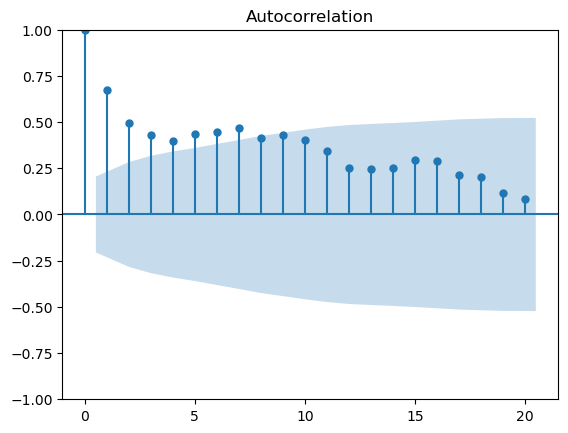

In [163]:
plot_acf(ipc['diff'].dropna())
plt.show()

#### $\nabla^2\text{IPC}$

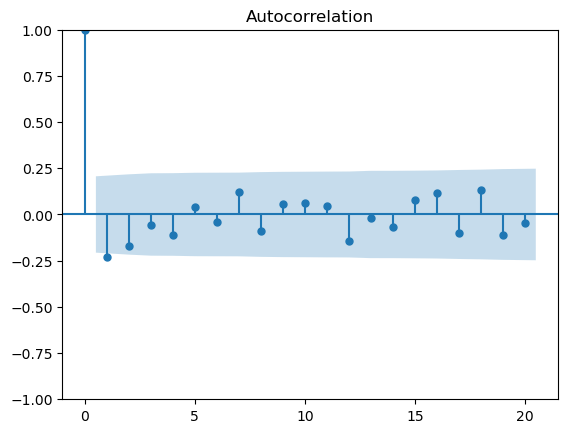

In [177]:
plot_acf(ipc['diff2'].dropna())
plt.show()

#### $\nabla\text{T(IPC)}$

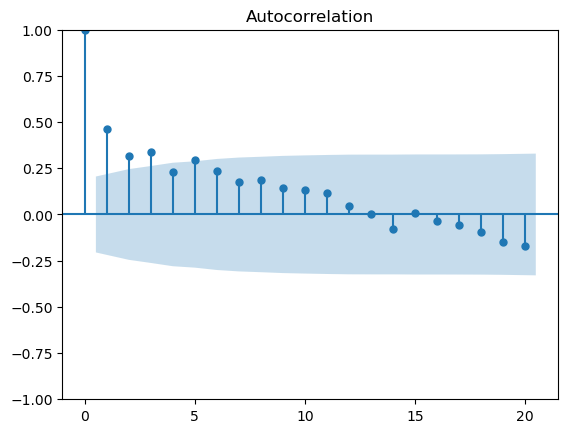

In [178]:
plot_acf(tipc['diff'].dropna())
plt.show()

#### $\nabla^2\text{T(IPC)}$

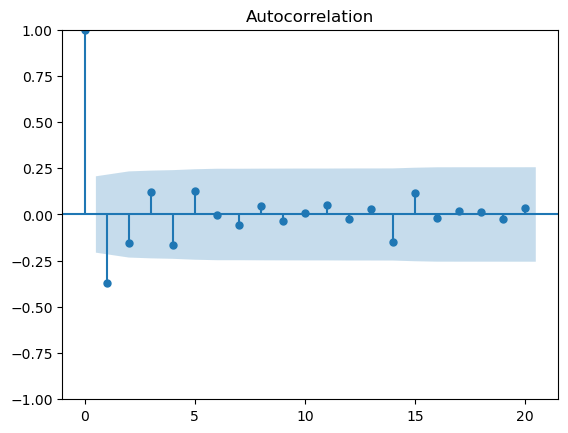

In [89]:
plot_acf(tipc['diff2'].dropna())
plt.show()

Se ve como un $\text{MA}(1)$, porque solo el primer lag es significativo y las demas autocorrelaciones dentro de las bandas azules no son significativamente distintas de cero.

###### **Explicación**

Las autocorrelaciones en una gráfica de Función de Autocorrelación (ACF) se consideran significativas si están fuera de las bandas azules, porque esto indica que la correlación observada no es explicable solo por ruido aleatorio.  

Las bandas azules en una gráfica de ACF representan el intervalo de confianza para la hipótesis nula:

$$
H_0: \rho(k) = 0
$$

donde $\rho(k)$ es la autocorrelación en el lag $k$.  

- Si un punto cae dentro de las bandas, la autocorrelación en ese lag no es significativamente diferente de 0 → No hay suficiente evidencia para decir que hay una correlación real en ese lag.  
- Si un punto cae fuera de las bandas, la autocorrelación en ese lag es significativamente diferente de 0 → Hay una correlación real en ese lag que no es explicable solo por ruido aleatorio.  

**¿Cómo se Calculan las Bandas Azules?**   

Para una serie de tiempo de $n$ observaciones, las bandas se aproximan con:  

$$
\pm \frac{1.96}{\sqrt{n}}
$$

Este intervalo proviene de la distribución normal estándar ($N(0,1)$), ya que bajo $H_0$, las autocorrelaciones deberían distribuirse aproximadamente como:  

$$
\rho(k) \sim \mathcal{N}\left(0, \frac{1}{n}\right)
$$

Para $n$ grande, se usa $\pm 1.96/\sqrt{n}$ para construir un intervalo de confianza del 95%.  

###### 

## **Modelado**

#### **Librerias**

In [90]:
from statsmodels.tsa.arima.model import ARIMA

#### $\nabla^2\text{IPC}$

In [113]:
arima021 = ARIMA(ipc['IPC'], order=(0,2,1)).fit()

In [115]:
arma01 = ARIMA(ipc['diff2'], order=(0,0,1)).fit()

#### $\nabla^2\text{T(IPC)}$

In [117]:
tarima021 = ARIMA(tipc["IPC"], order=(0,2,1)).fit()

c:\Users\herie\.conda\envs\data-mining\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [119]:
tarma01 = ARIMA(tipc['diff2'], order=(0,0,1)).fit()

c:\Users\herie\.conda\envs\data-mining\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## **Principio de Parsimonia**

##### **Pruebas de Significancia para Parámetros Estadísticos**

El principio de parsimonia, también conocido como la navaja de Occam, establece que entre varias explicaciones posibles para un fenómeno, la más sencilla es generalmente la correcta, siempre y cuando todas las explicaciones sean igualmente capaces de explicar los datos.

Para determinar si un parámetro estimado ($\beta$, $\lambda$, etc.) es significativo, se usa una prueba de hipótesis basada en su distribución muestral.  


**Plantear las hipótesis:**  

$$
H_0: \beta = 0  
\quad
\text{vs}
\quad
H_1: \beta \neq 0
$$  

- $H_0$: El parámetro no es significativo.
- $H_1$: El parámetro es significativo.  



**Calcular el estadístico de prueba, usualmente:**  
 - Prueba $t$:  
   $$
   t = \frac{\hat{\beta}}{\text{SE}(\hat{\beta})}
   $$  

 - Prueba $z$ en muestras grandes. $n>30$
   $$
   z = \frac{\hat{\beta} - \beta_0}{\text{SE}(\hat{\beta})}
   $$ 

donde $\hat{\beta}$ es el estimador del parámetro y $\text{SE}(\hat{\beta})$ es su error estándar.




**Obtener el p-valor:**  

   $$
   P(T > |t| \mid H_0) = p_{\text{valor}}
   $$   

Si $p$-valor < $\alpha$, rechazamos $H_0$ y concluimos que el parámetro es significativo.  

In [121]:
arima024 = ARIMA(ipc['IPC'], order=(0,2,4)).fit()
arima024.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    IPC   No. Observations:                   92
Model:                 ARIMA(0, 2, 4)   Log Likelihood                  -3.747
Date:                Thu, 06 Mar 2025   AIC                             17.493
Time:                        12:50:16   BIC                             29.992
Sample:                             0   HQIC                            22.534
                                 - 92                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4405      0.094     -4.675      0.000      -0.625      -0.256
ma.L2         -0.2678      0.113     -2.365      0.018      -0.490      -0.046
ma.L3         -0.0428      0.088     -0.487      0.626      -0.215       0.129
ma.L4         -0.0250      0.120     -0.209      0.835      -0.260       0.210
sigma2         0.0631      0.006     10.288      0.000       0.051       0.075
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                81.10
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               6.56   Skew:                             1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

*El coeficiente $\theta_3 = 0.626$ no es significativo porque su $p$-valor es mayor que 0.05.*  

$$
H_0: \theta_3 = 0 \quad \text{vs.} \quad H_1: \theta_3 \neq 0
$$
$$
p\text{-valor} = 0.626 > 0.05 \Rightarrow \text{No se rechaza } H_0.
$$

#### $\nabla^2\text{IPC}$

In [114]:
arima021.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    IPC   No. Observations:                   92
Model:                 ARIMA(0, 2, 1)   Log Likelihood                  -8.588
Date:                Thu, 06 Mar 2025   AIC                             21.177
Time:                        12:13:44   BIC                             26.176
Sample:                             0   HQIC                            23.193
                                 - 92                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6761      0.058    -11.723      0.000      -0.789      -0.563
sigma2         0.0704      0.007     10.680      0.000       0.057       0.083
===================================================================================
Ljung-Box (L1) (Q):                   4.50   Jarque-Bera (JB):                43.52
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               8.95   Skew:                             0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [116]:
arma01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  diff2   No. Observations:                   92
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  -8.415
Date:                Thu, 06 Mar 2025   AIC                             22.830
Time:                        12:13:58   BIC                             30.395
Sample:                             0   HQIC                            25.883
                                 - 92                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.011      0.505      0.613      -0.015       0.026
ma.L1         -0.6956      0.064    -10.887      0.000      -0.821      -0.570
sigma2         0.0701      0.008      9.211      0.000       0.055       0.085
===================================================================================
Ljung-Box (L1) (Q):                   5.13   Jarque-Bera (JB):                48.54
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              10.27   Skew:                             0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### $\nabla^2\text{T(IPC)}$

In [118]:
tarima021.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    IPC   No. Observations:                   92
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 910.701
Date:                Thu, 06 Mar 2025   AIC                          -1817.401
Time:                        12:14:08   BIC                          -1812.401
Sample:                             0   HQIC                         -1815.385
                                 - 92                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5275   8.36e-20  -6.31e+18      0.000      -0.528      -0.528
sigma2          1e-10   2.21e-10      0.452      0.651   -3.33e-10    5.33e-10
===================================================================================
Ljung-Box (L1) (Q):                   1.22   Jarque-Bera (JB):                15.05
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.72
Prob(H) (two-sided):                  0.57   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.05e+25. Standard errors may be unstable.
"""

In [120]:
tarma01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  diff2   No. Observations:                   92
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 929.241
Date:                Thu, 06 Mar 2025   AIC                          -1852.481
Time:                        12:14:25   BIC                          -1844.916
Sample:                             0   HQIC                         -1849.428
                                 - 92                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.539e-07    6.3e-07     -1.197      0.231   -1.99e-06     4.8e-07
ma.L1         -0.5274    9.9e-13  -5.33e+11      0.000      -0.527      -0.527
sigma2      9.295e-11   2.17e-10      0.428      0.668   -3.32e-10    5.18e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                16.81
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.55
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+25. Standard errors may be unstable.
"""

## **Analisis de Residuos**

#### **Obtener los residuos**

In [211]:
resarima021 = arima021.resid.dropna()
resarma01 = arma01.resid.dropna()
restarima021 = tarima021.resid.dropna()
restarma01 = tarma01.resid.dropna()

### **Media Cero**

##### mas info

$$
H_0: \beta = 0  
\quad
\text{vs}
\quad
H_1: \beta \neq 0
$$  

**Tabla comparativa** de las pruebas más comunes para evaluar si una variable tiene **media cero** (\(\mathbb{E}[X] = 0\)).  


**📌 Comparación de pruebas para media cero**  

| **Prueba**               | **Ventajas** | **Desventajas** | **Cuándo usarla** |
|--------------------------|-------------|----------------|------------------|
| **Prueba t de una muestra** | ✔ Fácil de interpretar. <br> ✔ Funciona bien si los datos son normales. <br> ✔ Muy utilizada en estadística. | ❌ Supone que los datos siguen una normal. <br> ❌ Puede perder precisión si la muestra es pequeña y la distribución no es normal. | Si los datos son **normales** o la muestra es grande (\(n > 30\)). |
| **Prueba de signo**      | ✔ No asume normalidad. <br> ✔ Robusta ante valores atípicos. | ❌ Menos potente que la prueba t si los datos son normales. | Si los datos pueden no ser normales o tienen **outliers**. |
| **Prueba de Wilcoxon (signed-rank)** | ✔ No asume normalidad. <br> ✔ Más potente que la prueba de signo. | ❌ Menos potente que la prueba t si los datos son normales. | Si los datos no son normales pero tienes suficientes observaciones (\(n > 10\)). |
| **Prueba Z de una muestra** | ✔ Funciona bien en muestras grandes. <br> ✔ Similar a la prueba t pero para \(n > 30\). | ❌ Supone que se conoce la varianza poblacional. | Si la muestra es **grande (\(n > 30\))** y conoces la varianza poblacional. |


**📌 ¿Qué prueba elegir?**
- 📌 **Si los datos son normales** → **Prueba t de una muestra**.  
- 📌 **Si la muestra es grande (\(n > 30\)) y conoces la varianza** → **Prueba Z**.  
- 📌 **Si los datos no son normales y pueden tener outliers** → **Prueba de signo**.  
- 📌 **Si los datos no son normales pero hay suficientes observaciones (\(n > 10\))** → **Prueba de Wilcoxon**.  
  

In [ ]:
from scipy.stats import t as t_dist

In [183]:
xres = resarima021.mean()
sres = resarima021.std()
n = len(resarima021)

In [184]:
t = xres/sres * n**0.5

In [190]:
p = 2 * t_dist.cdf(-abs(t), n-1)
p

0.6265782181358964

##### Implementación

In [234]:
from scipy.stats import ttest_1samp

ttest_1samp(resarima021, 0)

TtestResult(statistic=0.4882060649612207, pvalue=0.6265782181358963, df=91)

In [235]:
from scipy.stats import wilcoxon

wilcoxon(resarima021)

WilcoxonResult(statistic=2041.0, pvalue=0.7027567294577559)

In [236]:
from statsmodels.stats.descriptivestats import sign_test

sign_test(resarima021)

(-2.0, 0.7546517496104984)

### **Distribucion Normal**

##### **más info**

$$
H_0: \text{Distribución normal}
\quad
\text{vs}
\quad
H_1: \text{Distribución NO normal} 
$$  

| Prueba             | ¿Qué evalúa? | Ventajas | Desventajas |
|------------------------|-----------------|--------------|-----------------|
| Kolmogorov-Smirnov | Distribución empírica vs. normal estándar | Funciona en muestras grandes | No permite estimar media y varianza |
| Shapiro-Wilk | Normalidad en muestras pequeñas | Más potente en n < 50 | Menos confiable en n grandes |
| Jarque-Bera | Skewness y curtosis | Rápida, útil en modelos econométricos | No detecta diferencias en colas |
| D’Agostino-Pearson | Skewness y curtosis con corrección | Más precisa que Jarque-Bera en n grandes | No ideal para n pequeñas |
| Anderson-Darling | Diferencias en toda la distribución | Sensible a colas de la distribución | Más conservadora |
| Lilliefors | Kolmogorov-Smirnov ajustado | Permite estimar media y varianza | Menos potente en muestras pequeñas |

**📌 Comparación de pruebas de normalidad**  

| **Prueba**                | **Ventajas** | **Desventajas** | **Cuándo usarla** |
|---------------------------|-------------|----------------|------------------|
| **Shapiro-Wilk**          | ✔ Alta potencia en muestras pequeñas (< 50). <br> ✔ Sensible a desviaciones de normalidad. | ❌ No funciona bien en muestras grandes (> 5000). <br> ❌ Sensible a outliers. | Si la muestra es **pequeña** (n < 50). |
| **Kolmogorov-Smirnov (KS)** | ✔ Se puede usar con cualquier distribución teórica. <br> ✔ Funciona para grandes muestras. | ❌ Poco potente para detectar desviaciones sutiles de normalidad. <br> ❌ Depende de la distribución teórica elegida. | Si quieres comparar los datos con una **distribución específica**. |
| **Anderson-Darling (AD)** | ✔ Más potente que KS. <br> ✔ Detecta mejor problemas en las colas de la distribución. | ❌ Menos conocido que otras pruebas. <br> ❌ Necesita valores críticos específicos. | Si quieres evaluar **problemas en las colas** de la distribución. |
| **D’Agostino-Pearson (K²)** | ✔ Funciona bien con muestras grandes (> 50). <br> ✔ Evalúa sesgo y curtosis. | ❌ No es recomendable para muestras pequeñas. | Si la muestra es **grande** y quieres evaluar **asimetría y curtosis**. |
| **Jarque-Bera (JB)**      | ✔ Ampliamente usada en econometría y finanzas. <br> ✔ Basada en asimetría y curtosis. | ❌ No detecta desviaciones en las colas. <br> ❌ Puede fallar si los datos no tienen varianza constante. | Si trabajas con **series de tiempo o datos financieros**. |
| **Lilliefors**            | ✔ Versión mejorada de KS. <br> ✔ Se puede usar cuando la media y varianza no son conocidas. | ❌ Menos potente que Shapiro-Wilk o AD. | Si quieres una prueba como KS pero sin conocer la media y varianza de antemano. |

**📌 ¿Qué prueba elegir?**
- 📌 **Si la muestra es pequeña ($n < 50$)** → **Shapiro-Wilk**.  
- 📌 **Si la muestra es grande ($n > 50$)** → **D’Agostino-Pearson** o **Jarque-Bera**.  
- 📌 **Si te interesan las colas de la distribución** → **Anderson-Darling**.  
- 📌 **Si los datos vienen de un modelo financiero o econométrico** → **Jarque-Bera**.  
- 📌 **Si quieres una prueba flexible sin asumir media y varianza** → **Lilliefors**.  


#### Implementación

In [231]:
from scipy.stats import kstest
# Estadistico, p-valor
kstest(resarima021, 'norm')

KstestResult(statistic=0.32107767359058836, pvalue=6.14297768131239e-09, statistic_location=-0.2606930057314685, statistic_sign=-1)

In [230]:
from statsmodels.stats.diagnostic import lilliefors
# Estadistico, p-valor
lilliefors(resarima021)

(0.41876842740385, 0.0009999999999998899)

In [ ]:
from scipy.stats import jarque_bera

jarque_bera(resarima021)

SignificanceResult(statistic=13528.424136386064, pvalue=0.0)

In [ ]:
from scipy.stats import normaltest

normaltest(resarima021)

NormaltestResult(statistic=154.298723113036, pvalue=3.1221804043197816e-34)

In [233]:
from scipy.stats import anderson

anderson(resarima021)

AndersonResult(statistic=28.35396278149082, critical_values=array([0.554, 0.63 , 0.756, 0.882, 1.049]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.1802170379697535, scale=3.540679290012678)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

### **Varianza Constante**

#### mas info

$$
H_0: \text{Varianza constante (homocedasticidad)}
\quad
\text{vs}
\quad
H_1: \text{Varianza NO constante (heterocedasticidad)} 
$$  

Aquí tienes una tabla con las **ventajas y desventajas** de las pruebas más comunes para verificar **homocedasticidad** (varianza constante).  


**📌 Comparación de pruebas de homocedasticidad**  

| **Prueba**              | **Ventajas** | **Desventajas** | **Cuándo usarla** |
|-------------------------|-------------|----------------|------------------|
| **Breusch-Pagan**       | ✔ Fácil de interpretar. <br> ✔ Ampliamente usada en econometría. <br> ✔ Buena para heterocedasticidad lineal. | ❌ No detecta formas no lineales de heterocedasticidad. <br> ❌ Sensible a errores no normales. | Si sospechas que la varianza de los residuales depende de las variables explicativas. |
| **White**               | ✔ Detecta heterocedasticidad de cualquier tipo. <br> ✔ No necesita especificar la forma de la heterocedasticidad. | ❌ Puede perder potencia en muestras pequeñas. <br> ❌ Sensible a valores atípicos. | Si quieres detectar **cualquier** tipo de heterocedasticidad, no solo la lineal. |
| **Goldfeld-Quandt**     | ✔ Útil si la heterocedasticidad está en dos grupos de datos. <br> ✔ Fácil de implementar. | ❌ Menos potente si la heterocedasticidad es gradual en lugar de abrupta. | Si sospechas que la heterocedasticidad ocurre entre dos subconjuntos de datos. |
| **Levene**              | ✔ No asume normalidad en los datos. <br> ✔ Más robusto que Bartlett ante outliers. | ❌ Menos potente que Bartlett si los datos son normales. | Si los datos pueden **no ser normales**. |
| **Bartlett**            | ✔ Más potente que Levene si los datos son normales. | ❌ Muy sensible a valores atípicos. <br> ❌ No funciona bien si los datos no son normales. | Si los datos son **normales** y quieres máxima precisión. |
| **Brown-Forsythe**      | ✔ Versión mejorada de Levene, menos sensible a outliers. <br> ✔ Funciona bien en datos no normales. | ❌ Menos potente que Bartlett en datos perfectamente normales. | Si los datos pueden no ser normales, pero quieres evitar la sensibilidad extrema a outliers de Bartlett. |


**📌 ¿Qué prueba elegir?**
- 📌 **Si tienes datos de regresión:**  
  - **Breusch-Pagan** (heterocedasticidad lineal).  
  - **White** (heterocedasticidad en cualquier forma).  
- 📌 **Si divides los datos en dos grupos:**  
  - **Goldfeld-Quandt**.  
- 📌 **Si los datos pueden no ser normales:**  
  - **Levene** o **Brown-Forsythe** (menos sensibles a outliers).  
- 📌 **Si los datos son normales:**  
  - **Bartlett** (máxima potencia).  

#### implementacion

In [ ]:
from statsmodels.tools.tools import add_constant
add_constant(ipc[['IPC']])

,const,IPC
0,1.0,30.210
1,1.0,30.321
2,1.0,30.349
3,1.0,30.430
4,1.0,30.433
...,...,...
87,1.0,62.939
88,1.0,63.380
89,1.0,63.633
90,1.0,64.170


In [107]:
# Breusch-Pagan test
from statsmodels.stats.diagnostic import het_breuschpagan


# Add a constant to the exogenous variables
exog = add_constant(ipc[['IPC']])

# Perform the test
stat, p_value, _, _ = het_breuschpagan(residuals, exog)
print(f'Statistic: {stat}, p-value: {p_value}') # p-value > 0.05, homocedasticidad

Statistic: 1.6816738803827493, p-value: 0.19470218160211475


### **Independencia**

#### mas info

Aquí tienes una **comparación de las pruebas más comunes para evaluar independencia** entre variables.  




**📌 Comparación de pruebas de independencia**  

| **Prueba**               | **Ventajas** | **Desventajas** | **Cuándo usarla** |
|--------------------------|-------------|----------------|------------------|
| **Chi-cuadrado de independencia** | ✔ Fácil de interpretar. <br> ✔ Funciona bien con datos categóricos. | ❌ No funciona con datos numéricos continuos. <br> ❌ Puede ser poco precisa si hay celdas con frecuencias bajas. | Si ambas variables son **categóricas**. |
| **Coeficiente de correlación de Pearson** | ✔ Mide relación lineal entre dos variables numéricas. <br> ✔ Fácil de interpretar. | ❌ Solo detecta relaciones **lineales**. <br> ❌ Sensible a outliers. | Si ambas variables son **numéricas** y quieres ver si hay relación **lineal**. |
| **Coeficiente de correlación de Spearman** | ✔ Mide relación **monótona** (no solo lineal). <br> ✔ Más robusto ante valores atípicos. | ❌ Menos potente que Pearson si la relación es realmente lineal. | Si ambas variables son **numéricas**, pero la relación puede no ser lineal. |
| **Coeficiente de correlación de Kendall ($\tau$)** | ✔ Más robusto ante empates en los datos. <br> ✔ Más preciso en muestras pequeñas. | ❌ Computacionalmente más costoso que Spearman. | Si los datos tienen **muchos valores repetidos** o la muestra es pequeña. |
| **Prueba de Ljung-Box** | ✔ Específica para detectar correlación en series de tiempo. | ❌ Solo analiza autocorrelación, no correlación entre dos variables distintas. | Si trabajas con **series de tiempo** y quieres ver si hay autocorrelación. |
| **Mutual Information (Información Mutua)** | ✔ Detecta **cualquier** tipo de relación entre variables. <br> ✔ No supone ninguna forma específica de relación. | ❌ No tiene una interpretación fácil como Pearson o Spearman. | Si buscas relaciones **no lineales** entre dos variables. |




**📌 ¿Qué prueba elegir?**
- 📌 **Si ambas variables son categóricas** → **Chi-cuadrado de independencia**.  
- 📌 **Si ambas variables son numéricas y crees que la relación es lineal** → **Pearson**.  
- 📌 **Si ambas variables son numéricas pero la relación puede no ser lineal** → **Spearman** o **Kendall**.  
- 📌 **Si estás trabajando con series de tiempo** → **Ljung-Box**.  
- 📌 **Si quieres detectar cualquier tipo de relación sin supuestos** → **Mutual Information**.  




**📌 Ejemplo en Python: Prueba Chi-cuadrado**
```python
import scipy.stats as stats
import pandas as pd

# Crear tabla de contingencia
tabla = pd.crosstab(df['Variable1'], df['Variable2'])

# Prueba de Chi-cuadrado
chi2_stat, p_value, dof, expected = stats.chi2_contingency(tabla)
print(f"Estadístico Chi-cuadrado: {chi2_stat}, p-valor: {p_value}")

if p_value > 0.05:
    print("No se rechaza la independencia entre las variables")
else:
    print("Se rechaza la independencia, hay relación entre las variables")
```

✅ **Si $p > 0.05$** → No se rechaza $H_0$ (las variables son independientes).  
❌ **Si $p < 0.05$** → Se rechaza $H_0$ (las variables **no** son independientes).  




🔹 **¿Quieres probar alguna de estas pruebas con tus datos?** 🚀

#### Implementacion

### **Modelo admisible**

es Estacionario e einvertible